In [2]:
import warnings
warnings.filterwarnings('ignore')

import time
import math
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from fbprophet import Prophet
from scipy import stats
from psycopg2 import connect
import statsmodels.api as sm
import holidays as hol
import copy

from psycopg2.extras import execute_values
from psycopg2.extras import DictCursor
from snap_con import get_db_connection
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Graphical stuff
sns.set() 
sns.set(font_scale=1.2)
sns.set_style("ticks", {"xtick.major.size":8, "ytick.major.size":8})

In [3]:
# Query Functions
def query_data(db, query):
    con = connect(get_db_connection(db))
    result = pd.read_sql(query, con)
#     print(f"Data has {result.shape[0]} rows & {result.shape[1]} columns.")
    return result

# Same day - only include payments made on same day of caller
# FALSE includes both same day and scheduled payments
def get_data(from_date, to_date, product_RTO=True, same_day = True):
    
    if same_day:
        condition = 'AND ca.origination_date = ca.payment_dt'
    else:
        condition = ''

    if product_RTO:
        RTO = "="
    else:
        RTO ="<>"
            
    query = """
            SELECT ca.payment_dt AS date
            , SUM(payment_amount) AS dollars_collected
            FROM snapanalytics.collections_arrangements ca
            WHERE ca.arrangement_status = 'VERIFIED'
            AND ca.payment_dt >= '{0}'
            AND ca.payment_dt <= '{1}'
            AND product_type {2} 'RTO'
            {3}
            GROUP BY ca.payment_dt;
            """.format(from_date, to_date, RTO, condition)
    
    result = query_data('aws', query)
    result['date'] = pd.to_datetime(result['date'])
    
    return result

In [4]:
# Metric / other misc functions
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days) + 1


# Returns the date string of one day before
def one_day_before(d_str, ft="%Y-%m-%d"):
    return datetime.strftime(datetime.strptime(d_str, ft) + timedelta(days=-1), ft)


# Function that returns the first day of the current month
def firstDay(curr_dt=datetime.now()):
    return str(curr_dt.year) + '-' + str(curr_dt.month) + '-' + '01'


# Returns last day of current month
def lastDay(curr_dt=datetime.now()):
    return one_day_before(str(curr_dt.year + (curr_dt.month == 12)) + '-' + str(curr_dt.month % 12 + 1) + '-' + '01')


# Removes SNAP holidays from future predictions. Uses holidays package
def removeSnapHolidays(df, test_start_dt):
    yrs = np.unique([x.year for x in df[df['ds'] >= test_start_dt].iloc[:,0]])
    h = hol.US(years=yrs)

    for k,v in list(h.items()):
        if v in ["Washington's Birthday", "Martin Luther King, Jr. Day", "Columbus Day", "Veterans Day",
                "Veterans Day (Observed)"]:
            del h[k]
    dates = pd.Series(list(h))
    df.reset_index(drop=True)
    return df.drop(np.concatenate([np.where(x == df['ds'])[0] for x in dates]))

def holidays():
    # Tax Season (Feb and 5th+ week of year).
    holidays = pd.DataFrame({'holiday': 'taxseason'
                                , 'ds': pd.period_range('2015-01-01', '2050-12-31', freq='D')
                                , 'lower_window': -5
                                , 'upper_window': 5
                             })
    holidays['month'] = getattr(holidays['ds'].dt, 'month')
    holidays['week'] = getattr(holidays['ds'].dt, 'week')
    holidays = holidays[(holidays['month'] == 2) & (holidays['week'] > 5)]
    holidays.drop(['month', 'week'], axis=1, inplace=True)
    holidays['ds'] = holidays['ds'].values.astype('datetime64[M]')
    return holidays

def holidays2():
    # Tax Season (Feb and 5th+ week of year) as a window.
    holidays = pd.DataFrame({'holiday': 'taxseason'
                                , 'ds': pd.period_range('2015-01-01', '2050-12-31', freq='D')
                                , 'lower_window': -14
                                , 'upper_window': 21
                             })
    holidays['day'] = getattr(holidays['ds'].dt, 'weekday')
    holidays['week'] = getattr(holidays['ds'].dt, 'week')
    holidays = holidays[(holidays['week'] == 8) & (holidays['day'] == 0)]
    holidays.drop(['day', 'week'], axis=1, inplace=True)
    holidays['ds'] = holidays['ds'].values.astype('datetime64[D]')
    return holidays

def rmse(predictions, actuals): 
    return round(math.sqrt(((predictions-actuals)**2).mean()),2)

def mae(predictions, actuals): 
    return round((abs(predictions-actuals)).mean(),2)

def mape(predictions, actuals): 
    return round((abs(actuals - predictions) / actuals).mean(), 2)

def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)


In [5]:
# Will generate forecasts for time interval [start_dt, end_dt]. 
def compute_forecasts(model, start_dt, end_dt, trn_start_dt='2016-01-01', trn_end_dt=None, RTO=True,
                      same_day=False, ret_metrics=False, verbose=True, plotit=False):
    if trn_end_dt is None:
        trn_end_dt = one_day_before(start_dt)

    # Training Data
    collections_data = get_data(from_date=trn_start_dt, to_date=trn_end_dt, product_RTO=RTO, same_day=same_day)
    collections_data = collections_data.rename(columns={"date": "ds", "dollars_collected": "y"})
    collections_data = collections_data[collections_data['y'] > 0]

    # Model Fitting
    model.fit(collections_data)
    # Building Future df
    days_to_forecast = days_between(end_dt, start_dt) + \
                       days_between(start_dt, datetime.strftime(collections_data.iloc[-1,0], '%Y-%m-%d')) - 2
    future = model.make_future_dataframe(periods=days_to_forecast)
    future['Dayofweek'] = getattr(future['ds'].dt, 'dayofweek')

    # Excluding sundays / Observed Holidays
    future = removeSnapHolidays(future, start_dt)
    future = future[future['Dayofweek'] != 6]

    future.drop('Dayofweek', axis=1,inplace=True)

    # Forecasting
    forecast = model.predict(future)
    predictions = forecast[['ds', 'yhat']]
    predictions = predictions[predictions['ds'] >= start_dt]

    # Test Data
    test_data = get_data(from_date=start_dt, to_date=end_dt, product_RTO=RTO, same_day=same_day)
    test_data = test_data.rename(columns={'date' : 'ds', 'dollars_collected' : 'y'})

    # Combining Predictions and actual data
    final_df = pd.merge(predictions, test_data, how='left', on='ds')
    final_df['Predicted_Dollars'] = final_df['yhat'].cumsum()
    final_df['Actual_Dollars'] = final_df['y'].cumsum()
    final_df['Difference'] = final_df['Predicted_Dollars'] - final_df['Actual_Dollars']
    final_df['y'].fillna(0, inplace = True)

    # Model Score
    score_df = final_df[final_df['ds'] < datetime.today().strftime('%Y-%m-%d')]
    # Model score Printed
    if verbose:
        print(f"\nEstimated Dollars: ${round(final_df.tail(1)['Predicted_Dollars'].values[0],2)}")
        print(f"MAE: ${mae(score_df['yhat'], score_df['y'])}")
        # print(f"MAPE: {mape(score_df['yhat'], score_df['y'])}%")
        print(f"RMSE: ${rmse(score_df['yhat'], score_df['y'])}")
        print(f"CUM_MAE: ${mae(final_df['Predicted_Dollars'], final_df['Actual_Dollars'])}")
    
    # Results Comparison Charts
    if plotit:
        final_df.set_index('ds', inplace=True)
        fig = plt.figure(figsize=(16, 6))
        final_df = final_df.rename(columns={'y' : 'Dollars_Collected', 'yhat' : 'Dollars_Predicted'})
        sns.lineplot(data=final_df[['Dollars_Collected', 'Dollars_Predicted']])
        plt.xlabel('Date', weight='bold')
        plt.ylabel('Dollars', weight='bold')
        plt.show()
        
        fig = plt.figure(figsize=(16, 6))
        sns.lineplot(data=final_df[['Actual_Dollars', 'Predicted_Dollars']])
        plt.xlabel('Date', weight='bold')
        plt.ylabel('Dollars', weight='bold')
        plt.show()
             
        fig = plt.figure(figsize=(9, 3))
        plt.plot(score_df['ds'], score_df['Difference'])
        plt.axhline(0, color='red', ls='--')
        plt.title('Cumulative Difference')
        plt.xlabel('Date', weight='bold')
        plt.ylabel('Cumulative Predicted - Actual', weight='bold')
        plt.show()
    
        # Trends & Seasonal Charts
    
        plot1 = model.plot(forecast)
        plot2 = model.plot_components(forecast)
    
    # If you want to return the values from the testing set
    if ret_metrics:      
        metric_df = pd.Series([round(final_df.tail(1)['Predicted_Dollars'].values[0],2), 
                               mae(score_df['yhat'], score_df['y']), 
                               rmse(score_df['yhat'], score_df['y']), 
                               mae(final_df['Predicted_Dollars'], final_df['Actual_Dollars'])], 
                               index=['est','mae', 'rmse', 'Cmae'])
        return [metric_df, score_df]
    return score_df

In [6]:
# Cross validation -------------------------------------------------------------------------------------------------------------
## Global Variables
SAME_DAY = True
_RTO_ = False

# Render results of Cross-Validation dataframe
def render_res(res, params, sort='cmae', n=50):
    cols = np.concatenate([params, ['est', 'mae', 'rmse', 'cmae']])
    sort_col = np.where(cols == sort)[0][0]
    return pd.DataFrame(res[res[:,sort_col].argsort()], columns=cols).head(n)

# Run model through test set
def run_test_set(model, start='2019-07-02', end='2019-07-31'):
    cf_full = compute_forecasts(model=copy.deepcopy(model), start_dt=start, end_dt=end, RTO=_RTO_,
                            same_day=SAME_DAY, verbose=True, plotit=True)
    return cf_full

curr_dt = datetime.now() #+ timedelta(days=-50) # Adjust timedelta For validation set
START_DATE = firstDay(curr_dt)
END_DATE = lastDay(curr_dt)

<Figure size 864x288 with 0 Axes>

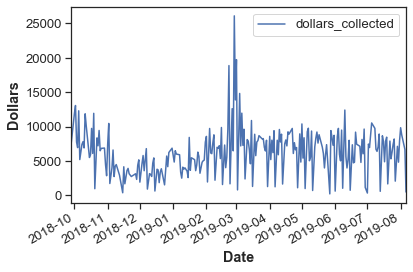

         mean_Col
weekday          
0        6827.422
1        6033.980
2        6688.172
3        6570.378
4        8435.304
5        1631.185
       mean_Col
month          
1      4834.427
2      8136.627
3      7666.183
4      6940.594
5      6820.982
6      6127.205
7      6454.652
8      6455.062
10     7591.050
11     3929.450
12     3908.536


In [13]:
# EDA
def plot_section(df, st_dt, end_dt):
    df_fin = df[(df['date'] >= st_dt) & (df['date'] <= end_dt)]
    fig = plt.figure(figsize=(12, 4))
    #dts = pd.date_range(df_fin[['date']])
    df[['date', 'dollars_collected']].set_index('date').plot()
    plt.xlabel('Date', weight='bold')
    plt.ylabel('Dollars', weight='bold')
    plt.show()

# Gets all data   
df = get_data('2018-01-01', datetime.now(), product_RTO=_RTO_, same_day = SAME_DAY)
df['year'] = getattr(df['date'].dt, 'year')
df['month'] = getattr(df['date'].dt, 'month')
df['week'] = getattr(df['date'].dt, 'week')
df['weekday'] = getattr(df['date'].dt, 'weekday')

# Graph since Oct 2018
plot_section(df, '2019-06-05', '2019-07-31')

# Summarize by week / Month
collDat_agg = df[df['date'] > '2018-10-01']
print(collDat_agg.groupby('weekday')['dollars_collected'].agg({'mean_Col' :np.mean})) # Friday is highest day
print(collDat_agg.groupby('month')['dollars_collected'].agg({'mean_Col' :np.mean})) # Spike Feb/Mar


Estimated Dollars: $167424.72
MAE: $1447.02
RMSE: $1814.5
CUM_MAE: $3136.1


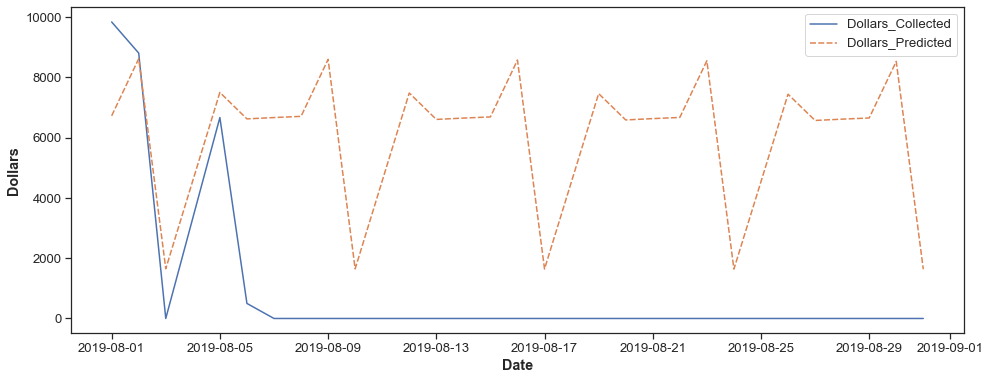

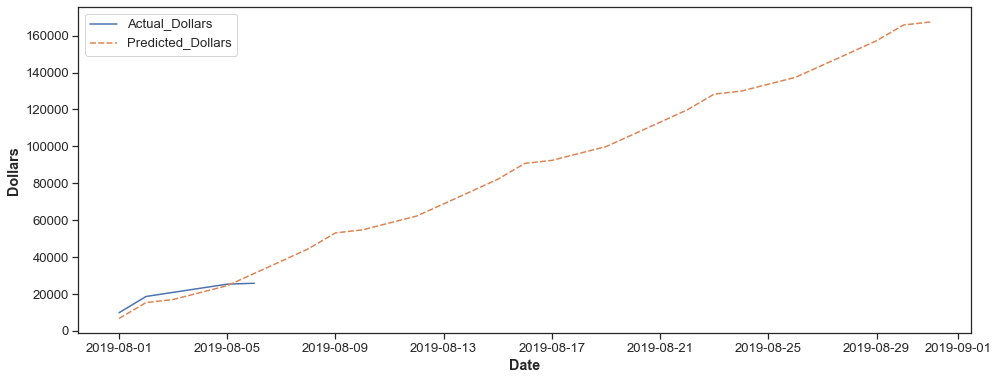

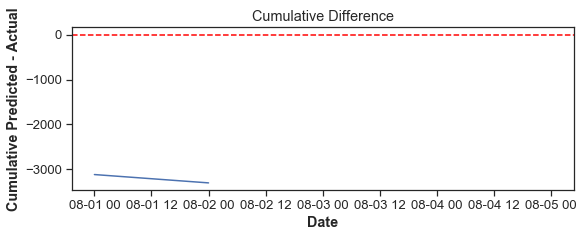


Estimated Dollars: $149309.48
MAE: $999.12
RMSE: $1218.1
CUM_MAE: $7687.4


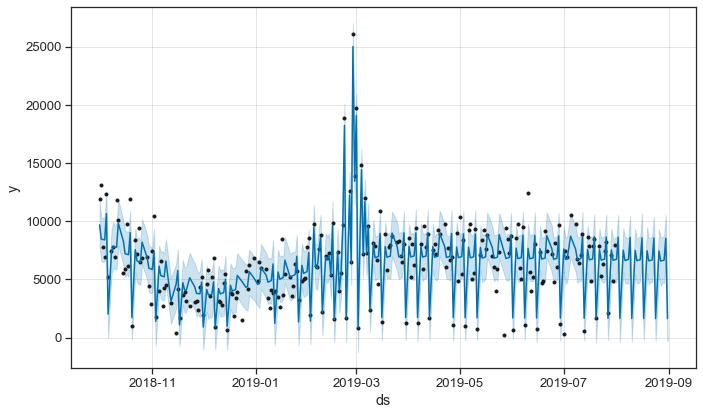

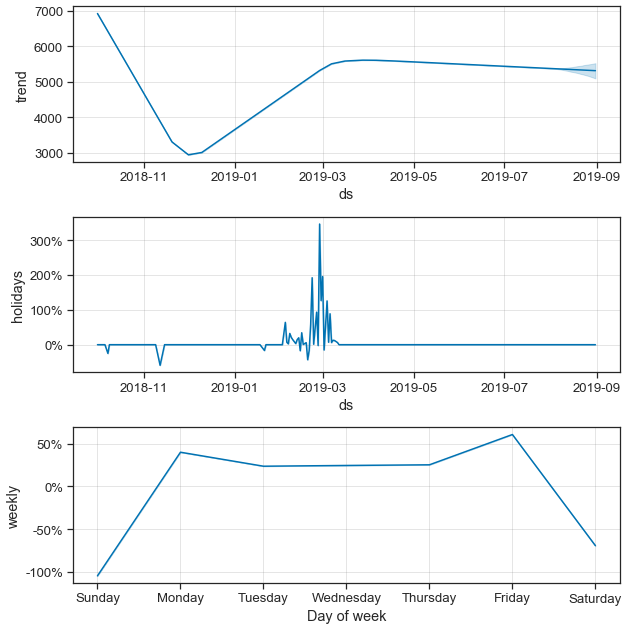

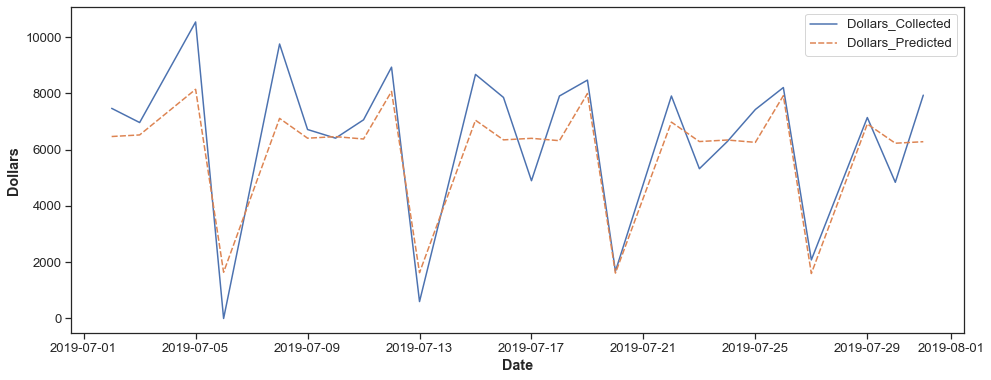

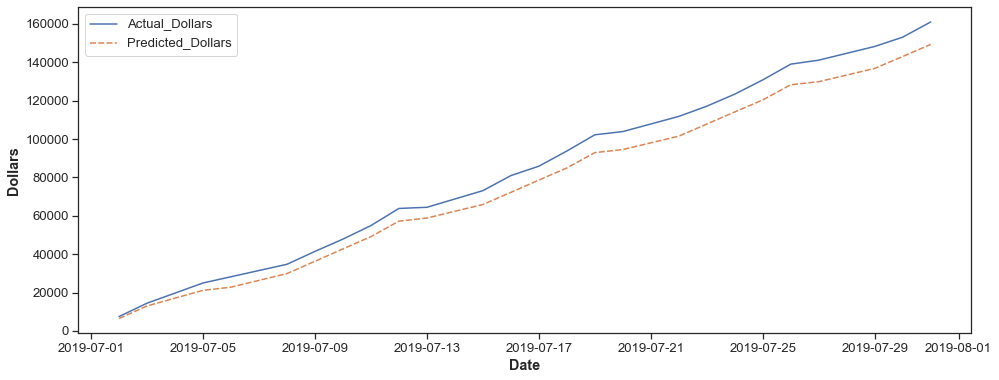

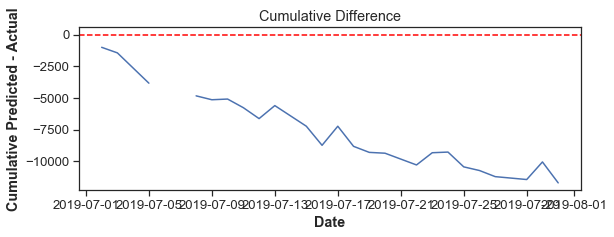

,ds,yhat,y,Predicted_Dollars,Actual_Dollars,Difference
0,2019-07-02,6464.285,7465.250,6464.285,7465.250,-1000.965
1,2019-07-03,6520.615,6960.820,12984.900,14426.070,-1441.170
2,2019-07-05,8141.622,10534.000,21126.522,24960.070,-3833.548
3,2019-07-06,1642.798,0.000,22769.320,nan,nan
4,2019-07-08,7108.444,9751.160,29877.764,34711.230,-4833.466
5,2019-07-09,6404.733,6712.840,36282.497,41424.070,-5141.573
6,2019-07-10,6460.465,6405.790,42742.962,47829.860,-5086.898
7,2019-07-11,6376.006,7057.430,49118.967,54887.290,-5768.323
8,2019-07-12,8066.320,8928.510,57185.287,63815.800,-6630.513
9,2019-07-13,1627.584,600.470,58812.871,64416.270,-5603.399


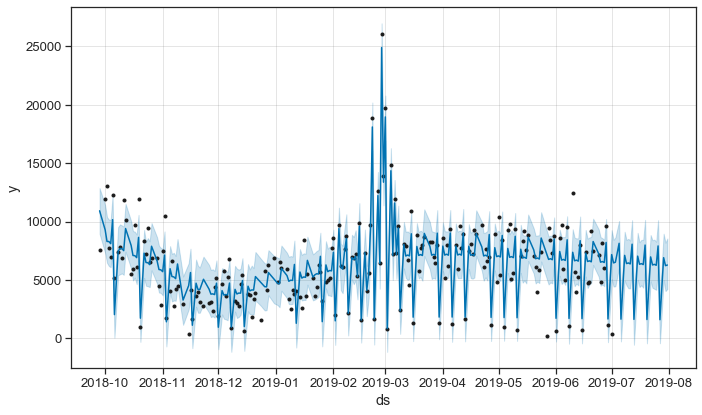

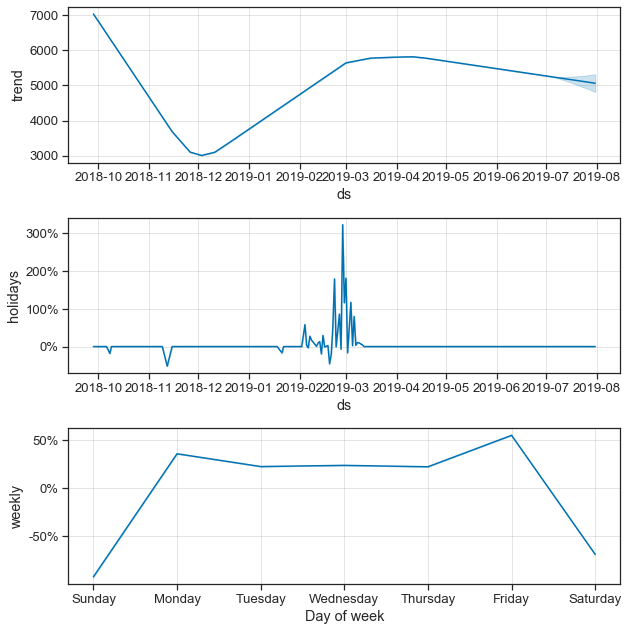

In [14]:
# Validation set to beat (No TUNING)
model_full = Prophet(seasonality_mode='multiplicative'
                     , holidays=holidays2()
                     , daily_seasonality=False, yearly_seasonality=False)
model_full.add_country_holidays(country_name='US')
#model_full.add_seasonality(name='monthly', period=30, fourier_order=8)
model_full2 = copy.deepcopy(model_full)

cf_full = compute_forecasts(model=model_full, start_dt=START_DATE, end_dt=END_DATE, RTO=_RTO_,
                            trn_start_dt = '2018-10-01', same_day=SAME_DAY, verbose=True, plotit=True, ret_metrics=True)

# Estimated Dollars: $171300.69
# MAE: $1723.93
# RMSE: $1988.52
# CUM_MAE: $10394.24

# "Default model" test set value
run_test_set(model_full2)
# Estimated Dollars: $144598.62
# MAE: $969.89
# RMSE: $1199.52
# CUM_MAE: $6088.02


Estimated Dollars: $177393.02
MAE: $1438.87
RMSE: $1737.18
CUM_MAE: $3086.66


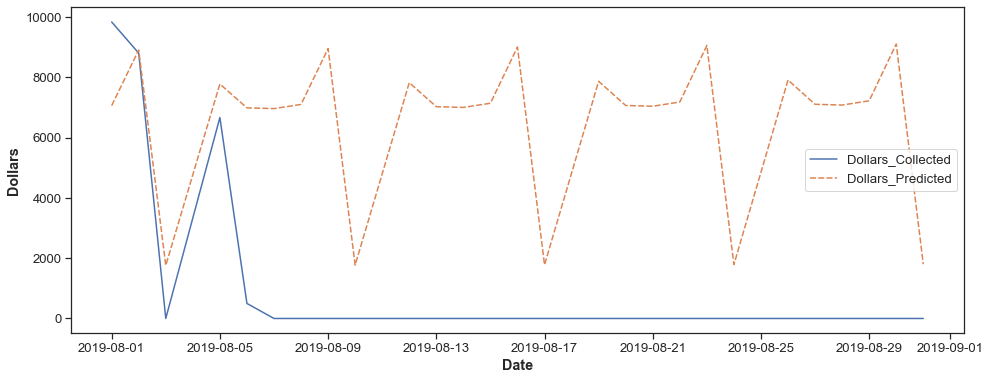

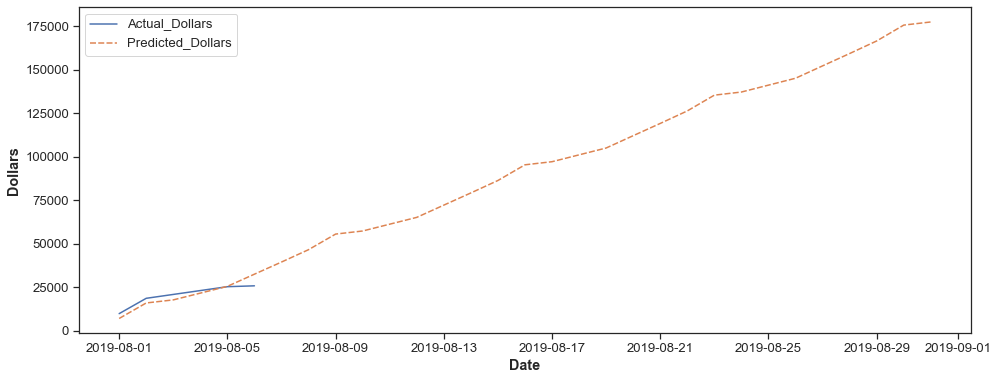

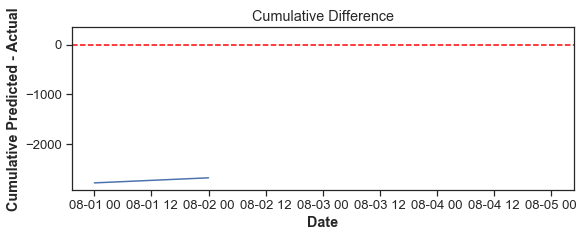

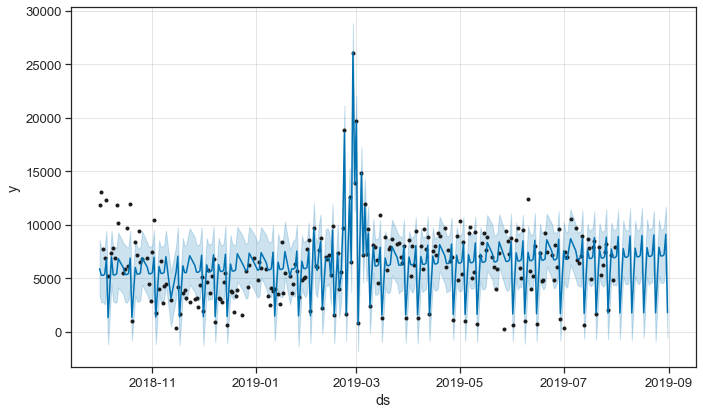

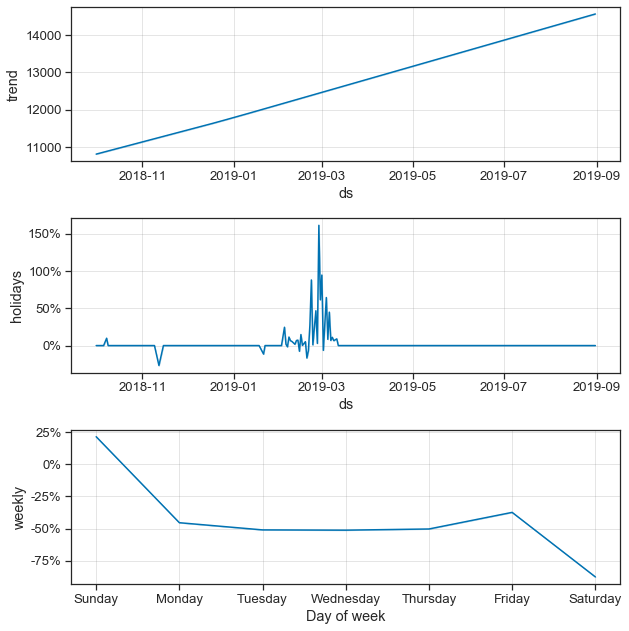

In [15]:
# Cross validation (Adjust this as you go) -------------------------------------------------------------------------------------
# Final model
model_full = Prophet(seasonality_mode='multiplicative'
                     , holidays=holidays2()
                     , daily_seasonality=False, yearly_seasonality=False
                     , seasonality_prior_scale=10, weekly_seasonality=10
                     , holidays_prior_scale=5, changepoint_range = .8, n_changepoints=25, changepoint_prior_scale=.034)
model_full.add_country_holidays(country_name='US')
# model_full.add_seasonality(name='monthly', period=30, fourier_order=5, prior_scale=7.5)

cf_full = compute_forecasts(model=copy.deepcopy(model_full), start_dt=START_DATE, end_dt=END_DATE, RTO=_RTO_,
                                    trn_start_dt = '2018-10-01', same_day=SAME_DAY, verbose=True, plotit=True)

#f = run_test_set(model_full)


In [16]:
# Forier Orders CV
s1 = np.arange(2,12) 
#s2 = [4,5,6,7,8,9,10,11]
s2 = [None]
resFO = np.zeros([len(s1)*len(s2),2+4])

for i in range(len(s1)):
    for j in range(len(s2)):
        model_full = Prophet(seasonality_mode='multiplicative'
                             , holidays=holidays2()
                             , daily_seasonality=False, yearly_seasonality=False
                             , seasonality_prior_scale=10, weekly_seasonality=s1[i])
        model_full.add_country_holidays(country_name='US')
        #model_full.add_seasonality(name='monthly', period=30, fourier_order=s2[j], prior_scale=10)
        
        cf_full = compute_forecasts(model=copy.deepcopy(model_full), start_dt=START_DATE, end_dt=END_DATE, RTO=_RTO_,
                                    trn_start_dt = '2018-10-01', same_day=SAME_DAY, verbose=True, plotit=False, ret_metrics=True)[0]
        resFO[j+len(s2)*i] = np.concatenate([[s1[i], s2[j]], cf_full])
        print('Testing Weekly Order {}, Monthly order {}'.format(s1[i],s2[j]))



Estimated Dollars: $173766.43
MAE: $1397.04
RMSE: $1608.27
CUM_MAE: $2999.37
Testing Weekly Order 2, Monthly order 1

Estimated Dollars: $167424.72
MAE: $1447.02
RMSE: $1814.5
CUM_MAE: $3136.1
Testing Weekly Order 3, Monthly order 1

Estimated Dollars: $166855.36
MAE: $1432.69
RMSE: $1806.73
CUM_MAE: $3127.99
Testing Weekly Order 4, Monthly order 1

Estimated Dollars: $167509.43
MAE: $1444.51
RMSE: $1811.7
CUM_MAE: $3128.06
Testing Weekly Order 5, Monthly order 1

Estimated Dollars: $166101.2
MAE: $1461.6
RMSE: $1829.99
CUM_MAE: $3157.4
Testing Weekly Order 6, Monthly order 1

Estimated Dollars: $164361.37
MAE: $1471.06
RMSE: $1852.42
CUM_MAE: $3183.41
Testing Weekly Order 7, Monthly order 1

Estimated Dollars: $165030.24
MAE: $1460.52
RMSE: $1841.07
CUM_MAE: $3167.72
Testing Weekly Order 8, Monthly order 1

Estimated Dollars: $164806.42
MAE: $1459.35
RMSE: $1841.29
CUM_MAE: $3173.99
Testing Weekly Order 9, Monthly order 1

Estimated Dollars: $165464.47
MAE: $1454.83
RMSE: $1840.71
CU

In [17]:
render_res(resFO, ['Week', 'Month'], sort='cmae')

,Week,Month,est,mae,rmse,cmae
0,2.000,1.000,173766.430,1397.040,1608.270,2999.370
1,4.000,1.000,166855.360,1432.690,1806.730,3127.990
2,5.000,1.000,167509.430,1444.510,1811.700,3128.060
3,3.000,1.000,167424.720,1447.020,1814.500,3136.100
4,6.000,1.000,166101.200,1461.600,1829.990,3157.400
5,11.000,1.000,165570.470,1462.310,1839.630,3161.300
6,8.000,1.000,165030.240,1460.520,1841.070,3167.720
7,10.000,1.000,165464.470,1454.830,1840.710,3168.670
8,9.000,1.000,164806.420,1459.350,1841.290,3173.990
9,7.000,1.000,164361.370,1471.060,1852.420,3183.410


In [21]:
# Prior Scales CV
s1 = np.concatenate([10**x*np.array([1,2.5,5,7.5]) for x in range(-2,3)])
#s2 = np.concatenate([10**x*np.array([1,2.5,5,7.5]) for x in range(-2,3)])
s2 = [None]
resSC = np.zeros([len(s1)*len(s2),2+4])
for i in range(len(s1)):
    for j in range(len(s2)):
        model_full = Prophet(seasonality_mode='multiplicative'
                             , holidays=holidays2()
                             , daily_seasonality=False, yearly_seasonality=False
                             , seasonality_prior_scale=s1[i], weekly_seasonality=10)
        model_full.add_country_holidays(country_name='US')
        #model_full.add_seasonality(name='monthly', period=30, fourier_order=9, prior_scale=s2[j])
        
        cf_full = compute_forecasts(model=copy.deepcopy(model_full), start_dt=START_DATE, end_dt=END_DATE, RTO=_RTO_,
                                    trn_start_dt = '2018-10-01', same_day=SAME_DAY, verbose=True, plotit=False, ret_metrics=True)[0]
        resSC[j+len(s2)*i] = np.concatenate([[s1[i], s2[j]], cf_full])
        print('Testing Weekly Scale {}, Monthly Scale {}'.format(s1[i],s2[j]))
render_res(resSC, ['week', 'month'])


Estimated Dollars: $180434.32
MAE: $2683.59
RMSE: $3390.03
CUM_MAE: $4201.95
Testing Weekly Scale 0.01, Monthly Scale None

Estimated Dollars: $172003.72
MAE: $1892.81
RMSE: $2280.24
CUM_MAE: $3295.44
Testing Weekly Scale 0.025, Monthly Scale None

Estimated Dollars: $170677.01
MAE: $1567.55
RMSE: $1917.82
CUM_MAE: $3129.49
Testing Weekly Scale 0.05, Monthly Scale None

Estimated Dollars: $167082.99
MAE: $1522.94
RMSE: $1875.22
CUM_MAE: $3170.81
Testing Weekly Scale 0.075, Monthly Scale None

Estimated Dollars: $168483.32
MAE: $1485.8
RMSE: $1841.84
CUM_MAE: $3132.66
Testing Weekly Scale 0.1, Monthly Scale None

Estimated Dollars: $164782.06
MAE: $1460.25
RMSE: $1841.12
CUM_MAE: $3173.4
Testing Weekly Scale 0.25, Monthly Scale None

Estimated Dollars: $165002.73
MAE: $1472.79
RMSE: $1845.19
CUM_MAE: $3177.57
Testing Weekly Scale 0.5, Monthly Scale None

Estimated Dollars: $164172.83
MAE: $1476.33
RMSE: $1852.43
CUM_MAE: $3191.64
Testing Weekly Scale 0.75, Monthly Scale None

Estimated

,week,month,est,mae,rmse,cmae
0,0.050,nan,170677.010,1567.550,1917.820,3129.490
1,0.100,nan,168483.320,1485.800,1841.840,3132.660
2,2.500,nan,165850.400,1442.290,1822.490,3145.750
3,1.000,nan,165486.530,1446.820,1826.970,3151.820
4,75.000,nan,165716.010,1448.840,1829.330,3156.380
5,750.000,nan,165330.210,1445.410,1827.570,3157.170
6,250.000,nan,165307.260,1445.890,1828.960,3157.290
7,25.000,nan,165436.660,1459.650,1839.050,3162.800
8,50.000,nan,165087.050,1452.090,1836.280,3163.070
9,10.000,nan,165464.470,1454.830,1840.710,3168.670


In [22]:
# Holidays CV
hd_sc = np.concatenate([10**x*np.array([1, 2.5, 5, 7.5]) for x in range(-1,2)])
resH = np.zeros([len(hd_sc), 1+4])
for i in range(len(hd_sc)):
    model_full = Prophet(seasonality_mode='multiplicative'
                         , holidays=holidays2()
                         , daily_seasonality=False, yearly_seasonality=False
                         , seasonality_prior_scale=10, weekly_seasonality=10
                         , holidays_prior_scale=hd_sc[i])
    model_full.add_country_holidays(country_name='US')
    #model_full.add_seasonality(name='monthly', period=30, prior_scale=7.5, fourier_order=9)
    
    cf_full = compute_forecasts(model=model_full, start_dt=START_DATE, end_dt=END_DATE, RTO=_RTO_,
                                trn_start_dt = '2018-10-01', same_day=SAME_DAY, verbose=True, plotit=False, ret_metrics=True)[0]
    resH[i] = np.concatenate([[hd_sc[i]], cf_full])
    print('Finished Holiday scale {}'.format(hd_sc[i]))



Estimated Dollars: $151857.5
MAE: $1445.92
RMSE: $1991.91
CUM_MAE: $3298.58
Finished Holiday scale 0.1

Estimated Dollars: $180279.98
MAE: $1478.73
RMSE: $1726.58
CUM_MAE: $3208.37
Finished Holiday scale 0.25

Estimated Dollars: $166370.07
MAE: $1438.41
RMSE: $1814.03
CUM_MAE: $3137.72
Finished Holiday scale 0.5

Estimated Dollars: $165433.43
MAE: $1437.96
RMSE: $1826.34
CUM_MAE: $3143.97
Finished Holiday scale 0.75

Estimated Dollars: $166798.25
MAE: $1446.54
RMSE: $1819.8
CUM_MAE: $3135.03
Finished Holiday scale 1.0

Estimated Dollars: $164626.23
MAE: $1483.23
RMSE: $1857.59
CUM_MAE: $3186.43
Finished Holiday scale 2.5

Estimated Dollars: $162751.14
MAE: $1463.2
RMSE: $1854.37
CUM_MAE: $3202.68
Finished Holiday scale 5.0

Estimated Dollars: $165393.16
MAE: $1453.89
RMSE: $1834.34
CUM_MAE: $3159.81
Finished Holiday scale 7.5

Estimated Dollars: $165464.47
MAE: $1454.83
RMSE: $1840.71
CUM_MAE: $3168.67
Finished Holiday scale 10.0

Estimated Dollars: $165438.62
MAE: $1448.26
RMSE: $183

In [23]:
render_res(resH, ['scale'])

,scale,est,mae,rmse,cmae
0,1.000,166798.250,1446.540,1819.800,3135.030
1,0.500,166370.070,1438.410,1814.030,3137.720
2,0.750,165433.430,1437.960,1826.340,3143.970
3,25.000,165438.620,1448.260,1831.760,3156.350
4,7.500,165393.160,1453.890,1834.340,3159.810
5,75.000,165449.770,1454.590,1835.100,3160.910
6,10.000,165464.470,1454.830,1840.710,3168.670
7,50.000,164234.760,1456.380,1843.590,3180.300
8,2.500,164626.230,1483.230,1857.590,3186.430
9,5.000,162751.140,1463.200,1854.370,3202.680


In [ ]:
# Changepoint CV
sc = np.concatenate([10**x*np.array([1,5]) for x in range(-2,2)])
sc= [.034]
num = [20,22,25,27,30]
r = [.7,.75,.8,.85,.9]
#num = [25]
#r = [.8]
resCP = np.zeros([len(sc)*len(num)*len(r),3+4])

for i in range(len(sc)):
    for j in range(len(num)):
        for k in range(len(r)):
            model_full = Prophet(seasonality_mode='multiplicative'
                                 , holidays=holidays2()
                                 , daily_seasonality=False, yearly_seasonality=False
                                 , seasonality_prior_scale=10, weekly_seasonality=10
                                 , holidays_prior_scale=5
                                 , n_changepoints = num[j], changepoint_range = r[k], changepoint_prior_scale = sc[i])
            model_full.add_country_holidays(country_name='US')
            #model_full.add_seasonality(name='monthly', period=30, prior_scale=7.5, fourier_order=9)

            cf_full = compute_forecasts(model=model_full, start_dt=START_DATE, end_dt=END_DATE, RTO=_RTO_,
                                        trn_start_dt = '2018-10-01', same_day=SAME_DAY, verbose=True, plotit=False, ret_metrics=True)[0]
            resCP[i*len(r)*len(num)+len(r)*j+k] = np.concatenate([[sc[i],num[j],r[k]], cf_full])
            print('Finished Changepoint Prior Scale {}, num change {}, proportion range {}'.format(sc[i],num[j],r[k]))


In [ ]:
# np.set_printoptions(suppress=True)
render_res(resCP, ['scale', 'num', 'prop'], sort='cmae')